# Statistical Machine Learning for Nonlinear PDEs #
### Sean Engelstad ###
$\newcommand{\mb}[1]{\textbf{#1}} \newcommand{\mbs}[1]{\boldsymbol{#1}}$
This document recreates the results of the paper *Solving and Learning Nonlinear PDEs with Gaussian Processes* by Yifan Chen, et al. Many physics problems from elasticity to fluid dynamics are solved by computers using hand-constructed solution methods from Finite Element Analysis to the Finite Volume Method. However, as physics problems become more advanced such as complicated constitutive models in elasticity, it would be of great benefit to the engineer if the machine could discover the best solution method using statistics. The paper provides a general framework which can solve nonlinear PDEs using collocation and kernel-based methods. The idea is to solve the PDE by approximating the solution of the PDE by the Maximum A Posterior (MAP) of a Gaussian Process conditioned on solving the nonlinear PDE at a finite number of collocation points. 

In this document, I recreated some of the results of the paper to understand how to implement their approach. Consider the following nonlinear PDE which is similar to the Poisson's equation on $\Omega = (0,1)^2$. 
$$ - \Delta u(x) + u^3(x) = f(x), \quad \forall x \in \Omega $$
$$ u(x) = 0, \quad \forall x \in \partial \Omega $$
Let the true solution $u^*(x) = \sin(\pi x_1) \sin(\pi x_2) + 4 \sin(4 \pi x_1) \sin(4\pi x_2) $ and determine the force $f(x)$ by plugging in $u^*(x)$ into the above PDE in the interior of the domain. Namely we have $f(x) = - \Delta u^*(x) + (u^*(x))^3$ which is prescribed. An approximate solution to the above nonlinear PDE can be written as follows which minimizes the norm $||u||$ and satisfies the PDE at a finite number of collocation points $M_{\Omega}$ on the interior and $M$ total points. 
$$ \min_{u \in \mathcal{U}} ||u||^2 $$
$$ \textrm{s.t.} -\Delta u(\mb{x}_m) + u(\mb{x}_m)^3 = f(\mb{x}_m), \quad \forall m : \; 1 \leq m \leq M_{\Omega}$$
$$ \textrm{and} \quad u(\mb{x}_m) = 0, \quad \forall m: \;  M_{\Omega}+1 \leq m \leq M $$

Consider the Gaussian process $GP \; \xi \sim \mathcal{N}(0,\mathcal{K})$ and a set of nonlinear observations $\phi_i \in \mathcal{U}^*$ the dual space of $u \in \mathcal{U}$. The Gaussian process can be conditioned on the nonlinear observations with $[\phi, \xi] \sim \mathcal{N}(0, \Theta)$ with covariance matrix defined as follows:
$$ \Theta_{i,j} = [\phi_i, \mathcal{K} \phi_j], \quad \forall i,j \in N $$
The operator $\mathcal{K}$ is related to the covariance function for the prior. The PDE optimization problem can similarly be constructed as an optimization problem on a set of nonlinear observations. The optimal solution $u^{\dagger} = \sum_{n=1}^N z_n^{\dagger} \chi_n$ is then a linear combination with weights $\mb{z}$ and the Gamblets $\chi_n$ among the observations below. 
$$ \chi_n = \sum_{i=1}^N \Theta_{i,n}^{-1} \mathcal{K} \phi_n $$

## Game Theory Problem on Collocation Points ##
We skip the majority of the remaining mathematical development in this demonstration (see the paper for more details). The optimal solution is then given by the kernel matrices and optimal weight vector $\mb{z}$ as follows:
$$ u(\mb{x}) = K(\mb{x}, \mbs{\phi}) K(\mbs{\phi}, \mbs{\phi})^{-1} \mb{z} $$
The optimal weights for the Gamblets are obtained by an optimization problem on $\mb{z}$, constrained by satisfying the PDE at the collocation points. Here the matrix $K(\mbs{\phi}, \mbs{\phi}) = \Theta$, a finite representation of  the covariance matrix from above. 
$$ \min_{\mb{z} \in \mathbb{R}^N} \mb{z}^T K(\mbs{\phi}, \mbs{\phi})^{-1} \mb{z} $$
$$ s.t. \quad F([\phi, \mb{z}]) = \mb{y} $$

## Covariance Matrices $K(x,\phi), K(\phi, \phi)$ ##
To compute the covariance matrices, we first need to define a kernel function $K(\cdot, \cdot)$. In this paper, they choose a Radial Basis function which is the Gaussian kernel. A hyperparameter is $\sigma$ the kernel distance, which is an important tuning parameter for solving the problem. 
$$ K(\mb{x}, \mb{y}) = \textrm{exp}(- \frac{|\mb{x} - \mb{y}|^2}{2 \sigma^2} )$$

The nonlinear PDE is constructed as a nonlinear algebraic function on a set of linear differential operators $L_1(u) = u$ and $L_2(u) = \Delta u$ on the interior and exterior/boundary of the domain. The nonlinear PDE operators are then written algebraically where $v_1 = u$, $v_2 = \Delta u$ on the interior:
$$ P u = - \Delta u + u^3 \equiv P(v_1, v_2) = v_1^3 - v_2  = y $$
And on the exterior:
$$ B u = u \equiv B(v_1) = v_1 = y $$
The nonlinear observations are then written in the form $F(\mb{z}) = \mb{y}$ where $\mb{z}$ are the chosen values of the linear differential operators on the interior and exterior of the domain $z = [v_{1,I}, v_{1,E}, v_{2,E}]^T \equiv [u_I, u_E, \Delta u_I]^T$. Note these are free variables for now. The nonlinear observations of the PDE at point $m$ with observed value $y_m$ is:
$$ F(\mb{z})_m = \begin{Bmatrix} P(\mb{z})_m, \quad \textrm{if interior} \\ B(\mb{z})_m, \quad \textrm{if exterior} \end{Bmatrix} = y_m $$

If there are $Q$ total linear differential operators, in this case 3 $L_1(u) = u$ and $L_2(u) = -\Delta u$ on the interior and also $L_1$ again on the exterior, then the collocation measurement vectors are $\phi_m^{(q)} = \delta_{\mb{x}_m} \odot L_q$ and are used to compute the collocation covariance matrices. The collocation covariance matrices are thus:
$$ K(\mb{x}, \phi)_{m,l}^{(j)} = L_j^{\mb{x}'} K(\mb{x}, \mb{x}')|_{(\mb{x}, \mb{x}')=(\mb{x}_m, \mb{x}_i)} $$
$$ K(\phi, \phi)_{m,l}^{(q),(j)} = L_q^{\mb{x}} L_j^{\mb{x}'} K(\mb{x}, \mb{x}')|_{(\mb{x}, \mb{x}')=(\mb{x}_m, \mb{x}_i)} $$
The exponents $(q), (j)$ represent block-diagonal components of the covariance matrices that corresponds to sections 1,2,3 of $\mb{z}$ and are (1): $L_1(u) = u$ observations on the interior, (2): $L_1(u) = u$ observations on the boundary, (3): $L_2(u) = -\Delta u$ observations on the interior. The derivatives of the covariance function under the Laplacian operator are the following where $\mb{x} \in \mathbb{R}^D$ so $D$ is the dimension of physical space. 
$$ K(\mb{x}, \mb{x}') = \textrm{exp}(- \frac{||\mb{x} - \mb{x}'||^2}{2 \sigma^2} )$$
$$ \Delta_{\mb{x}} K(\mb{x}, \mb{x}') = \Delta_{\mb{x}'} K(\mb{x}, \mb{x}') = K(\mb{x}, \mb{x}') \cdot \frac{||\mb{x} - \mb{x}'||^2 - D \sigma^2}{\sigma^4} $$
$$ \Delta_{\mb{x}} \Delta_{\mb{x}'} K(\mb{x}, \mb{x}') = K(\mb{x}, \mb{x}') \cdot \frac{ ||\mb{x} - \mb{x}'||^4 - 2 (2+D) \sigma^2 ||\mb{x} - \mb{x}'||^2 + D(2+D) \sigma^4}{\sigma^8} $$

The covariance matrices are then the following in block-diagonal form where we let $K_{ij} = K(X_i, X_j)$ and $X = [X_1, X_2, X_3]$ represents the coordinates in each of the three blocks 1 for interior, 2 for exterior and 3 for interior Laplacian. Note that $K_{ij} = K_{ji}$ for this kernel so the covariance matrices are symmetric except for $K(x, \phi)$.
$$ K(X, \Phi) = \begin{bmatrix} K(X_1, X_1) & K(X_1, X_2) & -\Delta_{x'} K(X_1, X_3) \\ K(X_2, X_1) & K(X_2, X_2) & -\Delta_{x'} K(X_2, X_3) \\ K(X_3, X_1) & K(X_3, X_2) & -\Delta_{x'} K(X_3, X_3) \end{bmatrix} $$
$$ K(\Phi, \Phi) = \begin{bmatrix} K(X_1, X_1) & K(X_1, X_2) & -\Delta_{x'} K(X_1, X_3) \\ K(X_2, X_1) & K(X_2, X_2) & -\Delta_{x'} K(X_2, X_3) \\ -\Delta_x K(X_3, X_1) & -\Delta_x K(X_3, X_2) & \Delta_x \Delta_{x'}K(X_3, X_3) \end{bmatrix} $$

In my experience and in the paper's, $K(\Phi, \Phi)$ matrix has determinant near 0 and is ill-conditioned by default. We add a small nugget matrix $K(\Phi, \Phi) += \eta R$ where $R$ is a block-diagonal set of identity-scaled matrices (see Appendix A.1). Below I setup the collocation points and the covariance matrices, as well as compute the inverse $K(\Phi, \Phi)^{-1}$.

X shape = (2300, 2)
Plotting the collocation points on interior and boundary..


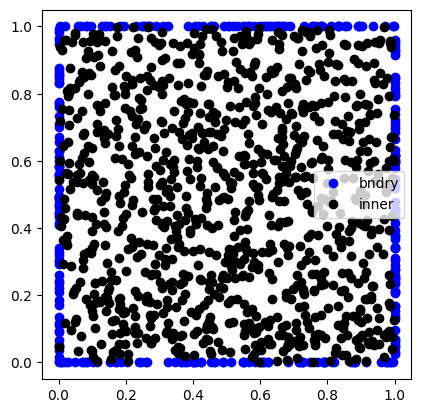

Building K(x,phi) and K(phi,phi) matrices...


In [ ]:
import numpy as np, matplotlib.pyplot as plt
import time
import sympy as sym

# CONFIGURATION SETTINGS
# --------------------------------------------------------
nB = 300 # num boundary points
nI = 1000 # num interior points in Omega = (0,1)^2

G_sigma = 0.2 # kernel hyperparameter
n_newton = 5 # num Newton iterations
eta = 1e-5

# ----------------------------------------------------------

# COLLOCATION POINTS AND FORCES
# ----------------------------------------------------------

# total number of opt pts (for linear operators)
N = 2 * nI + nB 
# randomly generated boundary points
xB = np.random.rand(nB,2)
for i in range(nB):
    grp = np.floor(i * 4 / nB) # 0,1,2,3 groups
    if grp == 0: # y = 0
        xB[i,1] = 0.0
    elif grp == 1: # x = 1
        xB[i,0] = 1.0
    elif grp == 2: # y = 1
        xB[i,1] = 1.0
    else: # x = 0
        xB[i,0] = 0.0

# randomly generated interior points
xI = np.random.rand(nI, 2)

# full set of points for linear operators
X = np.concatenate([xI, xB, xI], axis=0)
print(f"X shape = {X.shape}")

# get the forcing terms and forcing function
def ustar(x): # true solution
    x1 = x[0]; x2 = x[1]
    return np.sin(np.pi * x1) * np.sin(np.pi * x2) + 4 * np.sin(4 * np.pi * x1) * np.sin(4 * np.pi * x2)
x_sym = [sym.Symbol(f"x{i}") for i in range(2)]
x1 = x_sym[0]; x2 = x_sym[1]
ustar_sym = sym.sin(np.pi * x1) * sym.sin(np.pi * x2) + 4 * sym.sin(4 * np.pi * x1) * sym.sin(4 * np.pi * x2)
f_sym = sum([sym.diff(ustar_sym, x_sym[i], 2) for i in range(2)]) + ustar_sym**3

# true solution at each point
u_truth = np.array([ustar(X[i,:]) for i in range(N)])

def force(x):
    # use symbolic manipulation to get the force from the true solution
    # alternative might be to use complex-step method
    x1 = x[0]; x2 = x[1]
    return f_sym.subs(x_sym[0], x1).subs(x_sym[1], x2)

F_int = np.array([float(force(xI[i,:])) for i in range(nI)])

# plot the boundary and interior points
print("Plotting the collocation points on interior and boundary..")
plt.figure("collocationPts")
plt.plot(xB[:,0], xB[:,1], "bo", label="bndry")
plt.plot(xI[:,0], xI[:,1], "ko", label="inner")
plt.legend()
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()
plt.close("collocationPts")

# BUILD THE COVARIANCE / KERNEL MATRICES
# ------------------------------------------------------------------

def kernel(xm, xl, sigma=1, order=0):
    D = xm.shape[0]
    norm_sq = np.dot(xm-xl, xm-xl)
    if order == 0: # regular function
        return np.exp(-norm_sq/2.0/sigma**2)
    elif order == 1: # first Laplacian
        K = kernel(xm,xl,sigma=sigma, order=0)
        return 1 * K * (norm_sq - D * sigma**2) / sigma**4
    elif order == 2:
        K = kernel(xm,xl,sigma=sigma, order=0)
        return K * (norm_sq**2 - 2 * (2 + D) * norm_sq * sigma**2 + D * (2 + D) * sigma**4) / sigma**8

# construct cost matrix K(phi,phi) = Kpp and K(X,phi) = Kxp matrix
print("Building K(x,phi) and K(phi,phi) matrices...")
start_Theta = time.time()
Kpp = np.zeros((N,N))
Kxp = np.zeros((N,N))
for m in range(N):
    xm = X[m,:]
    m_2nd = m >= nB + nI # last group of pts, boolean for 2nd order operator
    for l in range(N):
        xl = X[l,:]
        l_2nd = l >= nB + nI
        deriv_order = 1.0 * (m_2nd + l_2nd)
        # double check the sign stuff here
        sgn1 = 1.0 if deriv_order == 1.0 else 1.0
        sgn2 = 1.0 if l_2nd else 1.0
        Kpp[m,l] = sgn1 * kernel(xm,xl,sigma=G_sigma, order=deriv_order)
        Kxp[m,l] = sgn2 * kernel(xm,xl,sigma=G_sigma, order=1.0 * l_2nd)

# add nugget to Kpp to improve condition number otherwise Kpp
# has det(Kpp) = 0 and the Gauss-Newton iterations do not converge (see Appendix A.1 in Y. Chen's paper)
# here I add the matrix eta * R to Kpp where R is an adaptive block-diagonal version of I
# since the omag of each block-diagonal section is different
trace11 = np.trace(Kpp[:nI, :nI])
trace22 = np.trace(Kpp[nI:nI+nB, nI:nI+nB])
trace33 = np.trace(Kpp[nI+nB:, nI+nB:])
Rvec = np.concatenate([
    np.ones((nI,)),
    (trace22/trace11) * np.ones((nB,)),
    (trace33/trace11) * np.ones((nI,))
])
R = np.diag(Rvec) # block-diagonal scaled nugget matrix
Kpp += eta * R

detKpp = np.linalg.det(Kpp)
print(f"det Kpp = {detKpp}", flush=True)

dt_Theta = time.time() - start_Theta
print(f"Built K(x,phi) and K(phi,phi) matrices in {dt_Theta} seconds.")
print(f"Inverting K(phi,phi) matrix...")
start_inv = time.time()
Kpp_inv = np.linalg.inv(Kpp)
delta_inv = time.time() - start_inv
print(f"K(phi,phi) = Theta matrix ({N},{N}) inverted in {delta_inv} seconds.")

## Newton's Method and Enforcing PDE Constraint ##
The nonlinear PDE constraint $F(\mb{z}) = \mb{y}$ can be enforced in more than one way. In this paper, we enforce it by direct substitution. Block components of $\mb{z} = [\mb{z}_1, \mb{z}_2, \mb{z}_3]$ where $\mb{z}_1 = \mb{u}$ on the interior and $\mb{z}_3 = \Delta \mb{u}$ on the interior of the domain $\Omega$. Here we set $\mb{z}_2 = g(\mb{x}_{\partial \Omega} = \mb{0}$ so the boundary constraints are automatically satisfied. Then we take the algebraic equation for the main PDE $P(v_1, v_2) = v_2 + v_1^3 = y$ and solve it for $v_2$ so that $v_2 = y - v_1^3$. Then the $z_1 = v_1$ block-component of $\mb{z}$ can be made unknown $\mb{w}$ vector and the constraints are enforced by substitution. The $\mb{z}(\mb{w};\mb{y}) = F(\mb{w}, \mb{y})$ vector is the following:
$$\mb{z} = [\mb{w}, \mb{0}, f(\mb{x}_{\Omega}) - \mb{w}^{\odot 3}]^T$$
The optimization problem for the optimal $\mb{z}$ is now an unconstrained problem for the optimal $\mb{w}$. 
$$ \min_{\mb{w} \in R^{N-M}} \mb{z}(\mb{w};\mb{y})^T K(\Phi, \Phi)^{-1} \mb{z}(\mb{w};\mb{y}) $$
The relation $\mb{z}(\mb{w})$ is nonlinear so the objective function is also nonlinear. We use linearizations through Gauss-Newton iterations to solve this nonlinear optimization problem. We then linearize the state $\mb{z}$ so the objective function becomes locally quadratic $L(\mb{w} + \delta \mb{w}) \approx L(\mb{w}) + \nabla_{\mb{w}} L^T \delta \mb{w} + \delta \mb{w}^T H_{\mb{w}} L \delta \mb{w}$ and solve for the minimum $\nabla_{\delta \mb{w}} L = 0$. The objective function on the linearized nonlinear state $\mb{z}$ is:
$$ L(\mb{w} + \delta \mb{w}) = (\mb{z} + \nabla_{\mb{w}} \mb{z}^T \delta \mb{w})^T K(\Phi, \Phi)^{-1} (\mb{z} + \nabla_{\mb{w}} \mb{z}^T \delta \mb{w}) $$
The gradient of the linearized objective function and the zero-slope condition is then.
$$ \nabla_{\mb{w}} L = 2 \nabla_{\mb{w}} \mb{z} K(\Phi, \Phi)^{-1} \mb{z} + 2 \nabla_{\mb{w}} \mb{z} K(\Phi, \Phi)^{-1} \nabla_{\mb{w}} \mb{z}^T \delta \mb{w} = \mb{0} $$
The Gauss-Newton update requires a linear solve and is essentially $\delta \mb{w} = - (H_{w} L)^{-1} \cdot \nabla_{w} L $:
$$ \delta \mb{w} = \left[ \nabla_{\mb{w}} \mb{z} \cdot K(\Phi, \Phi)^{-1} \cdot \nabla_{\mb{w}} \mb{z}^T \right]^{-1} \left[ \nabla_{\mb{w}} \mb{z} \cdot K(\Phi, \Phi)^{-1} \cdot \mb{z} \right] $$
The Jacobian matrix $\nabla_{\mb{w}} \mb{z}$ is the following and has dimensions $\mathbb{R}^{s(w) \times s(z)}$ where $s(\cdot)$ gets the size of a vector:
$$ \nabla_{\mb{w}} \mb{z} = \left[ 1_{\mb{w}}, \quad \mb{0}, \quad -\textrm{diag}(3 \mb{w}^{\odot 2}) \right] $$
Finally, the Newton update is $\mb{w}_{k+1} = \mb{w}_k + \alpha_k \delta \mb{w}_k$ where the learning rate $\alpha_k$ for this problem was chosen as $\alpha = 1$. 

In [ ]:
# NEWTON ITERATION
# ------------------------------------------------------------------------
# Newton iterations for optimal w weights
# could potentially store the sequence of w values if I want
print("Performing the Newton's iterations...")
start_newton = time.time()
w = np.zeros((nI,))

# useful functions
def z_func(w):
    z = np.concatenate([w, np.zeros((nB,)), F_int - w**3], axis=0)
    return np.reshape(z, newshape=(N,1))

def cost_func(w):
    z = z_func(w)
    return z.T @ Kpp_inv @ z

for inewton in range(n_newton):
    z = z_func(w)
    icost = cost_func(w)
    
    # Jacobian matrix J_ij = dzj/dwi = nabla_w z has dimension R^{s(w) x s(z)}
    dz_dw = np.concatenate([np.eye(nI), np.zeros((nI, nB)), -np.diag(3*w**2)], axis=-1)

    # Newton's iteration update dw = - Hinv * grad of objective
    # with matrix H = dz_dw * Kpp^-1 * dz_dw^T in R^(s(w) x s(w))
    H = 2 * dz_dw @ Kpp_inv @ dz_dw.T
    # gradient of objective is grad = dz_dw * Kpp_inv * z in R^(s(w) x 1)
    grad = 2 * dz_dw @ Kpp_inv @ z

    # perform the Newton's update on w
    dw = - np.linalg.solve(H, grad)

    # compute the new objective cost
    newz = z + dz_dw.T @ dw
    cost = newz.T @ Kpp_inv @ newz
    print(f"cost_{inewton} = {float(cost):.4e}")

    # unity learning rate
    w += dw[:,0]

z = np.concatenate([w, np.zeros((nB,)), F_int - w**3], axis=0)
z = np.reshape(z, newshape=(N,1))

# compute the solution vector u = Kxp * Kpp^-1 * z
u = Kxp @ Kpp_inv @ z
u = np.reshape(u, newshape=(N,))

dt_newtons = time.time() - start_newton
print(f"finished newton's iteration in {dt_newtons} sec.")

# DONE with NEWTON'S METHOD
# ------------------------------------------------------------------------

# PLOT AND REPORT SOLUTION
# -------------------------------------------------------------------------
plt.figure("nonlinear-poissons")
plt.scatter(X[:,0], X[:,1], c=u)
ax = plt.gca()
plt.title("approximate solution u")
ax.set_aspect('equal', adjustable='box')
plt.show()
plt.close("nonlinear-poissons")

# compute the solution residuals and plot them
uresid = u - u_truth
resid_norm = np.max(np.abs(uresid))
rel_resid_norm = resid_norm / np.max(np.abs(u_truth))
print(f"u residual norm = {rel_resid_norm:.4e}")

# plot the u solution error
plt.figure("nonlinear-poissons-error")
plt.scatter(X[:,0], X[:,1], c=uresid)
plt.title("error in solution u")
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()
plt.close("nonlinear-poissons-error")

## Use Kernels to Interpolate a 2D Mesh ##
Consider the original solution $u(\mb{x})$ given on random collocation points $\mb{X} \in R^{N \times d}$ matrix with solution vector $u \in R^{N \times 1}$. I now wish to extrapolate to some new points $X^* \in R^{M \times d}$ and solution $u^* \in R^{M \times 1}$ where $X^*$ is a flattened array of points on structured mesh. The book *Gaussian Processes for Machine Learning* assumes the prior on the training points $X$ and test points $X_*$ as:
$$ \begin{bmatrix} \mb{u} \\ \mb{u}_* \end{bmatrix} \sim \mathcal{N}(\mb{0}, \begin{bmatrix} K(X,X) & K(X, X_*) \\ K(X_*, X) & K(X_*, X_*) \end{bmatrix} )$$
The conditional distribution of the outputs of the test dataset given the training observations $f_*|X_*, X,f$ is the following:
$$ \mb{u}_*|X_*, X,\mb{u} \sim \mathcal{N}\left[K(X_*, X) K(X,X)^{-1} \mb{u}, K(X_*, X_*) - K(X_*, X) K(X,X)^{-1} K(X, X_*) \right] $$
Thus, the mean of the conditional distribution on the test set, using a nugget to make the kernel $K(X_*, X_*)$ invertible is and switching observations on the function $f, f*$ to the solution vector for our setting $u, u_*$.
$$ \overline{\mb{u}}_* = K(X_*, X) \left[ K(X,X) + \sigma_n^2 I \right]^{-1} \mb{u} $$
We then plot the interpolated solution on the 2d mesh below. The solution for $u(x)$ given in the journal article is the following:
![nonlinear-poisson](ref-soln.png)

In [ ]:
# make a 2D mesh with meshgrid
ngrid = 30
ngrid_sq = ngrid**2
sigma_n = 1e-4
x1vec = np.linspace(0,1,30)
x2vec = x1vec.copy()
X1, X2 = np.meshgrid(x1vec, x2vec)
# goes by row 1, row 2, etc. after flattened
X1flat = np.reshape(X1, newshape=(ngrid_sq,1))
X2flat = np.reshape(X2, newshape=(ngrid_sq,1))
Xstar = np.concatenate([X1flat, X2flat], axis=1)
#print(f"X1 = {X1[:5,:5]} shape = {X1.shape}, X1flat = {X1flat[:5]}, shape = {X1flat.shape}")
print("Building kernels K(X*,X) and K(X,X) for interpolating 2d mesh..")
Kxstar_x = np.array([[kernel(Xstar[i,:], X[j,:], sigma=G_sigma) for j in range(N)] for i in range(ngrid_sq)])
Kxx = np.array([[kernel(X[i,:], X[j,:], sigma=G_sigma) for j in range(N)] for i in range(N)])
print("Done building kernels")
print("Solving kernel inverse problem..")
ucol = np.reshape(u, newshape=(N,1))
ustar = Kxstar_x @ np.linalg.solve(Kxx+sigma_n**2 * np.eye(N), ucol)
print("Done solving kernel inverse proble, now plotting..")
X1plot = np.reshape(Xstar[:,0], (ngrid,ngrid))
X2plot = np.reshape(Xstar[:,1], (ngrid,ngrid))
uplot = np.reshape(ustar[:,0], (ngrid,ngrid))

# plot the interpolated solution
plt.figure("u-2d-mesh")
fig, ax = plt.subplots(1, 1)
ax.contourf(X1plot, X2plot, uplot)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
fig.colorbar()
plt.show()
plt.close("u-2d-mesh")